In [31]:
SEED = 116

In [32]:
#autoload modules in notebook
%load_ext autoreload
%autoreload 2  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
from itertools import combinations
import json
from sklearn.metrics import classification_report
from transformers import DistilBertTokenizer, TFDistilBertModel
import numpy as np
from numpy.linalg import norm
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
import cv2
from collections import Counter
from itertools import islice
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
import seaborn as sns
import os

import pickle 
import CLIP_model
import CLIP_data_load
import utils

In [34]:
# Hyperparameters
train_percentage = 0.8
test_percentage = 0.2
validation_percentage = 0.15
latent_dim_imgs = 1024
latent_dim_text = 768
latent_dim_common = 512
batch_size = 128
img_shape = (128,128,3)
text_input_shape = (200)
max_len = 200
bert_model_name = 'distilbert-base-uncased'


# Paths
all_images_path = 'dataset/resized_train/'
dataset_extract_location = 'dataset/'
project_location = '/home/ale/Documents/University_arc/University/MSc/Transformers/project'
all_captions_path = f'{project_location}/dataset/caption_prediction_train.csv'  
all_concept_ids_path = f'{project_location}/dataset/concept_detection_train.csv'
all_concepts_path = f'{project_location}/dataset/concepts.csv'

zip_dataset_location = f'{project_location}/dataset/resized_train.zip'
model_loc = f'{project_location}/weights/clip_improvement_3.h5'

In [35]:
!pwd

/bin/bash: /home/ale/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/home/ale/Documents/University_arc/University/MSc/Transformers/project


In [36]:
%cd {project_location}
os.chdir(project_location)

/home/ale/Documents/University_arc/University/MSc/Transformers/project


### Data load

In [37]:
# # Extract images
# import zipfile

# with zipfile.ZipFile(zip_dataset_location) as zf:
#   for member in tqdm(zf.infolist(), desc='Extracting '):
#     try:
#         zf.extract(member, dataset_extract_location)
#     except zipfile.error as e:
#         pass

Extracting :   0%|          | 0/83276 [00:00<?, ?it/s]

In [38]:
#Merging all dataframes toghether into ID, caption, cuis, concepts
captionsDF = pd.read_csv(all_captions_path, sep='\t')
concept_id_df = pd.read_csv(all_concept_ids_path, sep='\t')
concept_df = pd.read_csv(all_concepts_path, sep=',')

concepts = concept_df.set_index('concept').T.to_dict('list')
concept_id_df.cuis = concept_id_df.cuis.apply(lambda x: x.split(';'))
concept_id_df['concepts'] = concept_id_df.cuis.apply(lambda cuis: {concepts[cui][0] for cui in cuis})

captionsDF = pd.merge(captionsDF,concept_id_df, on="ID")
captionsDF.ID = captionsDF.ID.apply(lambda x: x+'.jpg')

In [39]:
train_val, test = train_test_split(captionsDF, test_size = test_percentage, shuffle = False, random_state = SEED)
train, val = train_test_split(train_val, test_size = validation_percentage, shuffle = False, random_state = SEED)

In [40]:
tokenizer = DistilBertTokenizer.from_pretrained(bert_model_name)

testList = CLIP_data_load.paths_captions_emb_list(test, all_images_path,tokenizer=tokenizer,max_len=max_len)

100%|██████████| 16655/16655 [00:06<00:00, 2679.92it/s]


In [41]:
test_gen = CLIP_data_load.ClipBaseGenerator(
    data = testList,
    batch_size = batch_size,
    out_shape = img_shape[0:2],
    shuffle = False,
    seed=SEED,)

  0%|          | 0/130 [00:00<?, ?it/s]

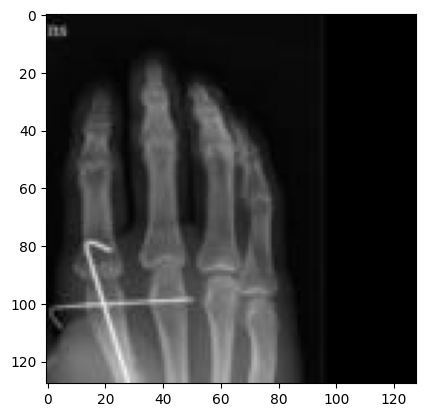

In [42]:
for i,(batch_image,batch_ids,batch_masks) in enumerate(tqdm(test_gen)):#8,64,64,3 and 8,512
#     img = cv2.imread(img_path)
#     img = cv2.resize(img, (img_size))
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert BGR to RGB
    plt.imshow(batch_image[0,:,:])
    break

## Load model

In [43]:
bert_model = TFDistilBertModel.from_pretrained(bert_model_name)

loaded_model = tf.keras.models.load_model(model_loc, 
                                          custom_objects={'TFDistilBertModel': bert_model,
                                                          'CustomModel':CLIP_model.CLIP_base,
                                                          'clip_loss':CLIP_model.clip_loss})

2023-06-19 17:35:54.666823: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the

In [44]:
def embed_img(batch_img):
  text_zeros = tf.zeros([batch_img.shape[0],200])
  return embed(batch_img,text_zeros,text_zeros)[1]

def embed_txt(batch_ids,batch_att):
  image_zeros = tf.zeros([batch_ids.shape[0],img_shape[0],img_shape[0],3])
  return embed(image_zeros,batch_ids,batch_att)[0]

def embed(batch_img,batch_ids,batch_att):
    e_txt,e_img = loaded_model.predict_step((batch_img,batch_ids,batch_att))
    return e_txt.numpy(),e_img.numpy()

class Data:
    def __init__(self,emb_txt,emb_img,df):
        lenght = emb_txt.shape[0]
        self.ids = list(df['ID'])[:lenght]
        self.captions = list(df['caption'])[:lenght]
        self.labels = list(df['labels'])[:lenght]
        self.paths = [all_images_path+name for name in self.ids]
        self.text = emb_txt
        self.img = emb_img
        self.text_of = {id:text for id,text in zip(self.ids,self.text)}
        self.img_of = {id:img for id,img in zip(self.ids,self.img)}
        self.caption_of = {id:capt for id,capt in zip(self.ids,self.captions)}
    #len
    def __len__(self):
        return self.text.shape[0]

In [45]:
# e_txt, e_img = loaded_model.predict(test_gen,workers=2)
# embed_test = Data(e_txt,e_img,test)
# pk = pickle.dumps(embed_test)
# with open("weights/embed_test2.pkl", "wb") as f:
#     f.write(pk)
with open('weights/embed_test2.pkl', 'rb') as f:
    embed_test = pickle.load(f)


In [46]:
# Print functions
def print_similar(id_simscore_tuples,embed_data,max_print_similar):

    similar = islice(reversed(id_simscore_tuples),0,max_print_similar)
    for i,(id,v) in enumerate(similar):
        print(f"{id} {v} {embed_data.caption_of[id]}")

def print_different(id_simscore_tuples,embed_data,max_print_different):

    reversed_vals = reversed(id_simscore_tuples[:max_print_different])
    for i,(id,v) in enumerate(reversed_vals):
        print(f"{id} {v} {embed_data.caption_of[id]}")

def show_top_n_images(id_simscore_tuples,embeds, max_print):
    similar = islice(reversed(id_simscore_tuples),0,max_print)
    for i,(id,v) in enumerate(similar):
        print(f"{id} {v} {embeds.caption_of[id]}")
        img_path = f'{all_images_path}{id}'
        #read color image
        img = cv2.imread(img_path)
        plt.imshow(img)
        plt.show()

# Get functions

def get_similar_text(text,ids,embed_texts):  
  
    tokenized_word = CLIP_data_load.construct_encoding(text,tokenizer,max_len, return_tensors="tf")
    e_txt = embed_txt(tokenized_word['input_ids'],tokenized_word['attention_mask'])
    
    distances_vals = np.dot(embed_texts,e_txt.T) #Cosine similarity. The vectors are already normalized
    distances = dict(zip(ids,distances_vals))

    id_simscore_tuples = sorted(distances.items(), key=lambda item: item[1])

    return id_simscore_tuples

def get_similar_images_from_text(text,ids,embed_imgs):  
  
  tokenized_word = CLIP_data_load.construct_encoding(text,tokenizer,max_len, return_tensors="tf")
  e_txt = embed_txt(tokenized_word['input_ids'],tokenized_word['attention_mask'])

  distances_vals = np.dot(embed_imgs,e_txt.T) #Cosine similarity. The vectors are already normalized
  distances = dict(zip(ids,distances_vals))

  id_simscore_tuples = sorted(distances.items(), key=lambda item: item[1])

  return id_simscore_tuples

def get_similar_images(image_name, ids, embed_imgs):
    image_path = f'{all_images_path}{image_name}.jpg'
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    e_img = embed_img(image[None,:])

    distances_vals = np.dot(embed_imgs, e_img.T)  # Cosine similarity. The vectors are already normalized
    distances = dict(zip(ids, distances_vals))

    id_simscore_tuples = sorted(distances.items(), key=lambda item: item[1])

    return id_simscore_tuples

# Functions to call

def print_similar_text(query,embed_data,max_print_similar = 10,max_print_different = 10):

    id_simscore_tuples = get_similar_text(query,embed_data.ids,embed_data.text)

    print_similar(id_simscore_tuples,embed_data,max_print_similar)

    print('...')

    print_different(id_simscore_tuples,embed_data,max_print_different)

def show_similar_images_from_path(image_name, embed_data, max_print_similar=10, max_print_different=10):
    id_simscore_tuples = get_similar_images(image_name, embed_data.ids, embed_data.img)

    show_top_n_images(id_simscore_tuples, embed_data, max_print_similar)

    print_different(id_simscore_tuples,embed_data,max_print_different)


def show_similar_images_from_text(query,embeds,max_print_similar = 10,max_print_different = 10):
    id_simscore_tuples = get_similar_images_from_text(query,embeds.ids,embeds.img)
    show_top_n_images(id_simscore_tuples,embeds, max_print_similar)

# Metrics

def new_rr(distances_vals,target_image_path, paths, n):
    
    full_dist = [paths[i] for i in np.argsort(distances_vals)[::-1]]

    distances =  full_dist[0:n]

    # Get rank based on the distance between the most similar image (in position 0 of the array) and the target image
    if target_image_path in distances:
        return 1/(distances.index(target_image_path) + 1)
    else:
        return 0

def compute_mrr(embed_data, n):
    collect_rr = []
    sim_matrix = np.dot(embed_data.text,embed_data.img.T) #Cosine similarity. Image to caption.

    pbar = tqdm(range(len(embed_data.paths)))
    for i in pbar:#8,64,64,3 and 8,512
        path = embed_data.paths[i]
        newrr = new_rr(sim_matrix[i,:],path,embed_data.paths,n)
        # print(newrr)
        collect_rr.append(newrr)
        if i % 1000 == 0:
            pbar.set_description(f"Average score = {np.average(collect_rr)}")

    return np.average(collect_rr)

def new_recall_at_k(distances_vals,target_image_id, ids, k):
    
    full_dist = [ids[i] for i in np.argsort(distances_vals)[::-1]]

    act_set = set([target_image_id])
    pred_set = set(full_dist[0:k])
    result = len(act_set & pred_set) / float(len(act_set)) # The & operator is used for the set intersection
    # Get rank based on the distance between the most similar image (in position 0 of the array) and the target image
    return result

def compute_recall_at_k(embed_data, k):
    sim_matrix = np.dot(embed_data.text,embed_data.img.T) #Cosine similarity. Image to caption.
    collect_rr = []
    pbar = tqdm(range(len(embed_data.paths)))
    for i in pbar:#8,64,64,3 and 8,512
        id = embed_data.ids[i]
        newrr = new_recall_at_k(sim_matrix[i,:].T,id,embed_data.ids,k)
        collect_rr.append(newrr)
        if i % 1000 == 0:
            pbar.set_description(f"Average score = {np.average(collect_rr)}")

    return np.average(collect_rr)



In [47]:
print_similar_text('icd in situ',embed_test,max_print_similar = 5,max_print_different = 5)

2023-06-19 17:36:04.203040: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


ImageCLEFmedCaption_2022_train_070468.jpg [0.99999964] icd in situ
ImageCLEFmedCaption_2022_train_068663.jpg [0.7174741] netter syndrome obliteration of entire uterine cavity due to extensive synechiae formation giving of glove finger appearance
ImageCLEFmedCaption_2022_train_069455.jpg [0.71468616] anteroposterior radiograph of the lumbar spine show enlargement of the left transverse process of the fifth lumbar vertebra upper arrow enlarge transverse process low arrow anomalous articulation with the  sacral ala with arthritic change
ImageCLEFmedCaption_2022_train_067149.jpg [0.712312] postoperative anteroposterior xray image of aspen show the spike in the lateral plate of the device for bone fixation
ImageCLEFmedCaption_2022_train_067637.jpg [0.71135175] right lateral radiograph of a nineyearold spay female german shepherd dog reveal hepatic nodular masse on the caudal visceral margin of right liver lobe irregular visualization be enhance by the negative contrast provide by air in gas

In [48]:
# print('Image -> Caption MRR@100 :', compute_mrr(embed_test, 100))
k = 100
# print(f'Image -> Caption   R@{k}:', compute_recall_at_k(embed_test, k))

ImageCLEFmedCaption_2022_train_079572.jpg 0.9999998807907104 the sagittal midline  study obtain  month postoperatively follow iliac autograft and dynamic abc plate placement document an adequate fusion observe the lack of lucency and the presence of bony trabeculation at the graftvertebral body interface superiorly and inferiorly a further fusion criterion be the lack of lucency surround the vertebral screw also note the  mm of cephalad and caudad screw migration within the plate minimize stress shielding and allow for graft settlingfusion


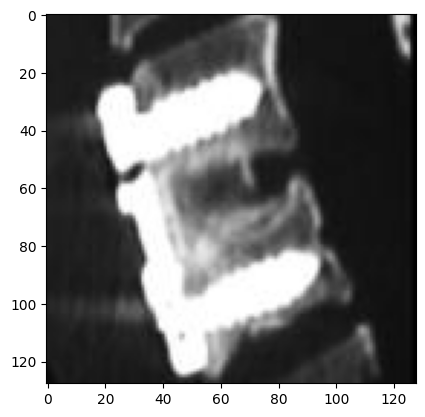

ImageCLEFmedCaption_2022_train_074699.jpg 0.9814711809158325 sagittal  magnetic resonance image of spine at admbesion there be longitudinal hyperintense signal involve the central cord from  downwards


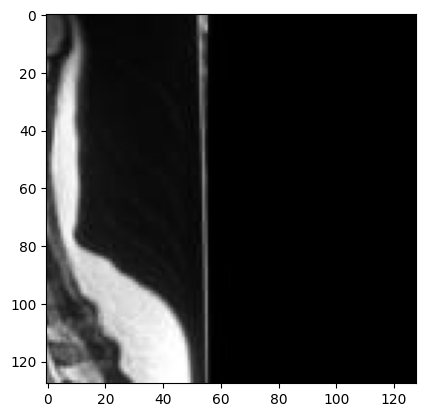

ImageCLEFmedCaption_2022_train_077010.jpg -0.35155045986175537 cross section ct show coil shunt and hydrocephalus
ImageCLEFmedCaption_2022_train_076195.jpg -0.35568687319755554 computerized tomography show posterior mediastinal cystic mass  cm


In [49]:
show_similar_images_from_path('ImageCLEFmedCaption_2022_train_079572',embed_test,max_print_similar = 2,max_print_different=2)

ImageCLEFmedCaption_2022_train_076263.jpg [0.692145] axial computed tomography section at  obtain  year after osteochondroma resection there be no evidence of tumor recurrence and the spinal canal remains decompress


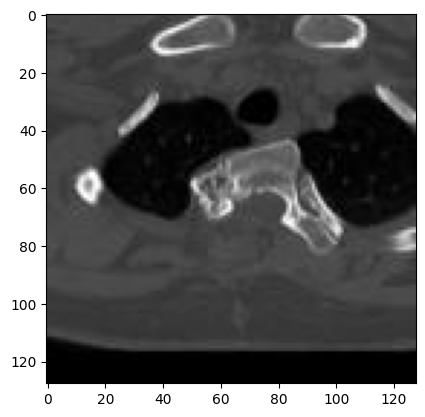

ImageCLEFmedCaption_2022_train_079498.jpg [0.6901264] axial ct image of the neck without oral or intravenous contrast demonstrate an air fluid collection in the left thyroid lobectomy bed white arrow subcutaneous emphysema and a large anterior neck air fluid collection asterisk be also present t residual right lobe of the thyroid


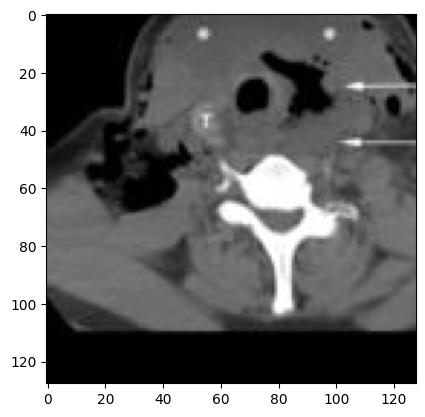

ImageCLEFmedCaption_2022_train_077105.jpg [0.6899956] axial ct of  scan show the extent of the involvement of the left lamina and compression of the cord the cauliflower appearance correspond to the ossified matrix of the osteochondroma huge intraspinal mass with heterogeneous density thbe ossified matrix be surround by cartilage tbesue the osseous tumour originate from the left  facet joint arrow


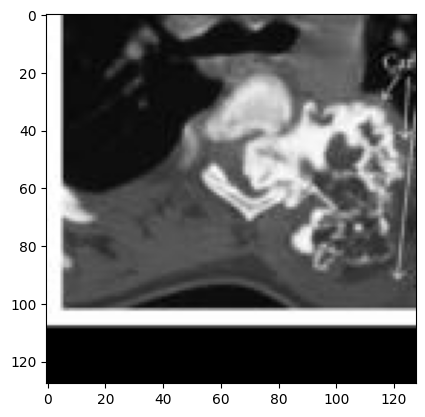

ImageCLEFmedCaption_2022_train_079559.jpg [0.6899377] axial compute tomography scan of sacrum show bony fractured piece in the spinal canal


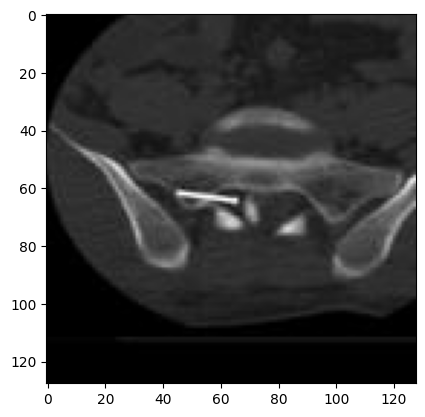

ImageCLEFmedCaption_2022_train_077476.jpg [0.6899069] thbe axial computed tomography ct obtain at the mid pedicle level document ventralanterior calcificationossification thbe be often mbeinterpreted as a calcified dbec but be in fact ossification of the posterior longitudinal ligament


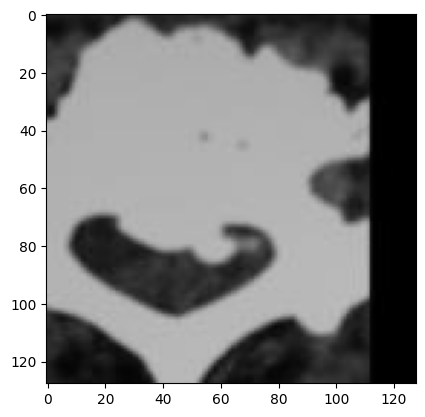

ImageCLEFmedCaption_2022_train_076304.jpg [0.6876639] ct scan of  level white arrow show airbubble


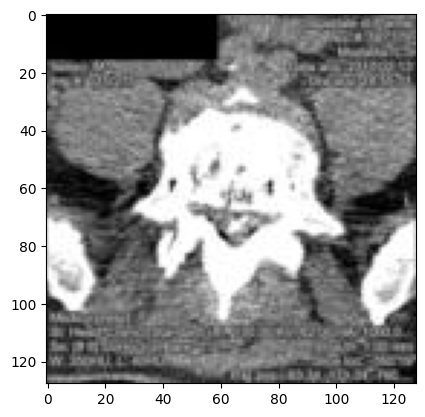

ImageCLEFmedCaption_2022_train_077820.jpg [0.68761885] computer tomography image transverse ct image show the automatically determine boundary the outer limit of the skin be mark with white dot the inner margin of subcutaneous adipose tbesue be mark with black dot note in thbe particular image the algorithm mberepresents the desire boundary in place because it be interrupt by dbecontinuities within the adipose tbesue


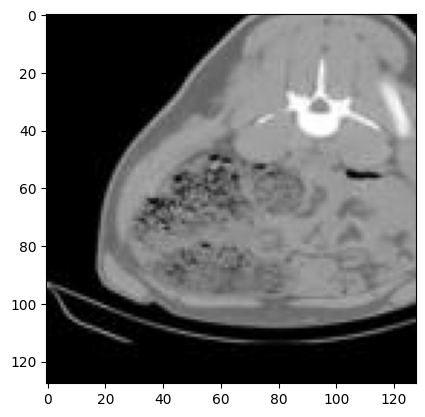

ImageCLEFmedCaption_2022_train_068835.jpg [0.68726325] computer tomograph axial image show involvement of scapula and multiple sequestra


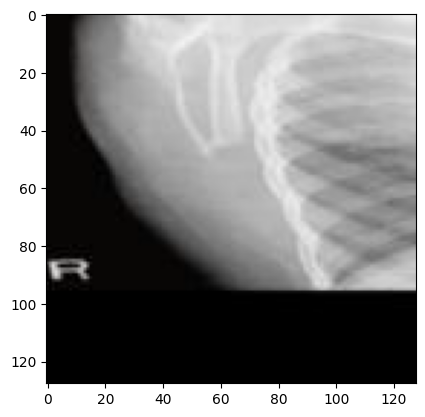

ImageCLEFmedCaption_2022_train_079711.jpg [0.6872375] axial ct image use for needle localization during a ctguide core biopsy use a  biopsy needle arrow


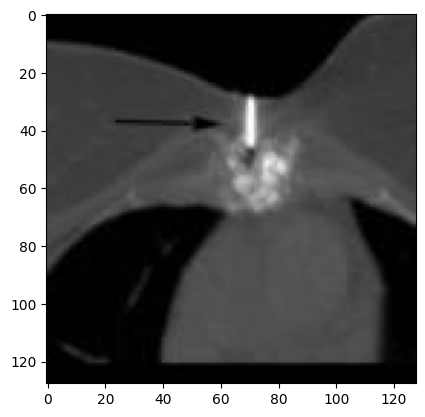

ImageCLEFmedCaption_2022_train_079198.jpg [0.6870965] thbe transaxial ct examination readily demonstrate the smoothlayer sign associate with opll see at the dbec space level alone the smoothlayer sign be rarely associate with a cerebrospinal fluid fbetula during  surgery


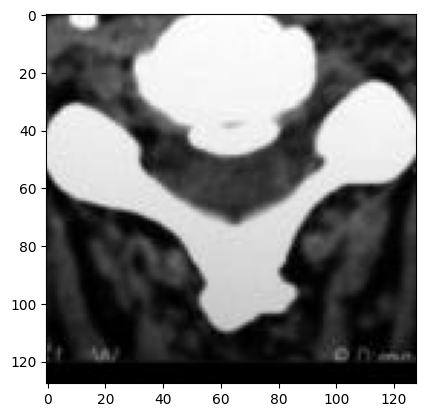

ImageCLEFmedCaption_2022_train_078723.jpg [0.6855925] axillary compute tomography scan show the expansion of the dissection to the iliac artery


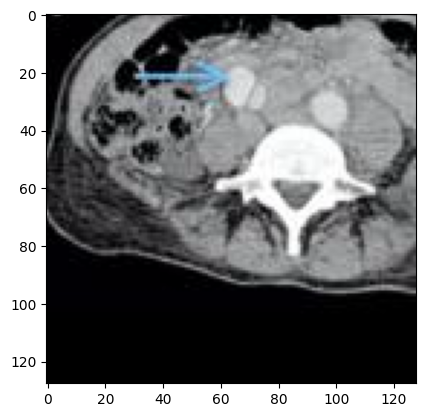

ImageCLEFmedCaption_2022_train_079835.jpg [0.6845375] preop ct


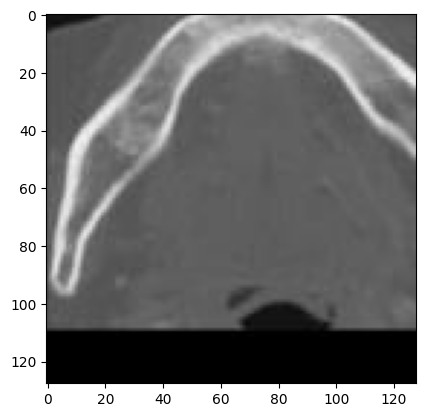

ImageCLEFmedCaption_2022_train_078416.jpg [0.68419725] radiationinduce fibrosarcoma  after radiotherapy of a  man axial contrastenhance ct image show a large heterogeneously mark enhance tumor with wide invasion into the muscle in the right low neck arrow


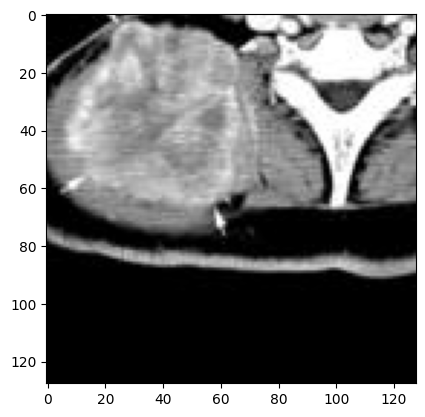

ImageCLEFmedCaption_2022_train_079268.jpg [0.68382525] axial compute tomography scan show  highgrade stenosis with calcification of the intervertebral disc and posterior osteophyte


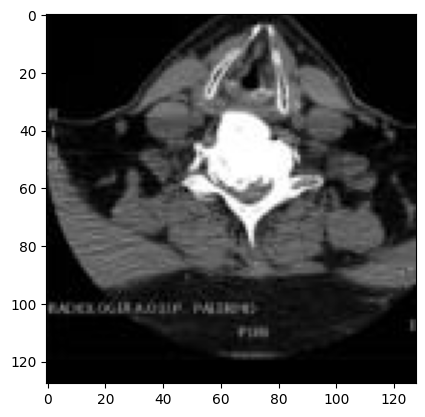

ImageCLEFmedCaption_2022_train_078696.jpg [0.68350685] computed tomography carotid angiography show the high density mass  of right neck connect with a branch of the subclavicular artery and compress the right carotid artery and trachea


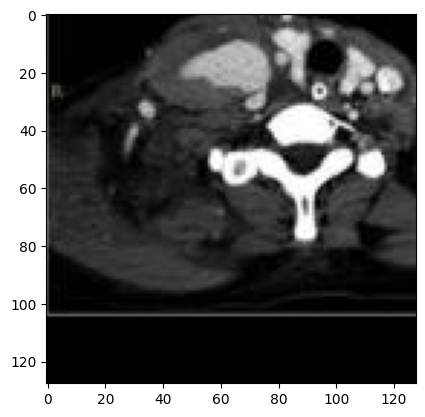

ImageCLEFmedCaption_2022_train_078644.jpg [0.6833308] transverse section of ct angiogram show radial artery aneurysm at right hand arrow


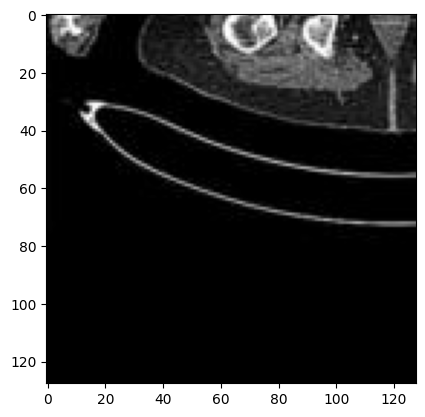

ImageCLEFmedCaption_2022_train_083167.jpg [0.6829654] axial view of the cect neck show a lobulate hypodense soft tissue mass measure   it occupy the left thyroid bed from  to  vertebral level


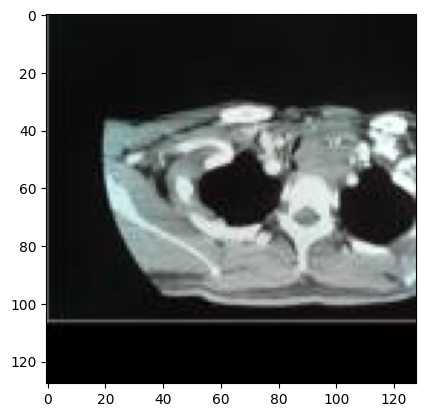

ImageCLEFmedCaption_2022_train_076557.jpg [0.68271923] neck compute tomography show cystic hygroma in the left neck trachea and thyroid gland deviate to right side


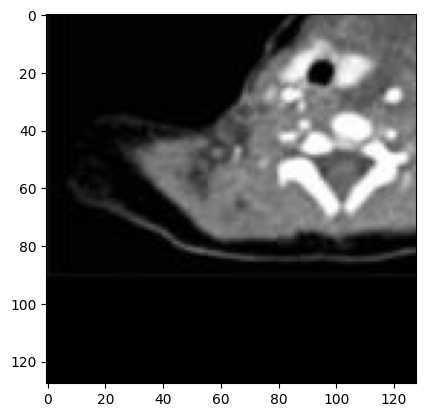

ImageCLEFmedCaption_2022_train_076788.jpg [0.68176687] computerized tomography of the neck with contrast enhancement demonstrate a large nodule with irregular wall and internal calcification in the right lobe of the thyroid


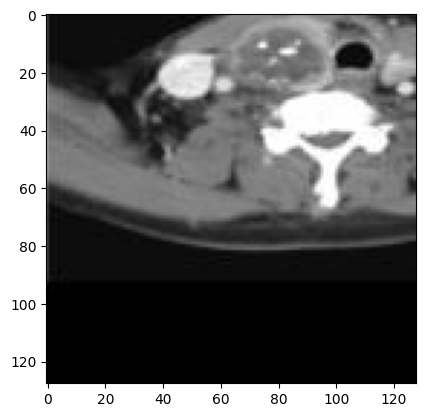

ImageCLEFmedCaption_2022_train_081624.jpg [0.68152916] computed tomography show destruction at  in case


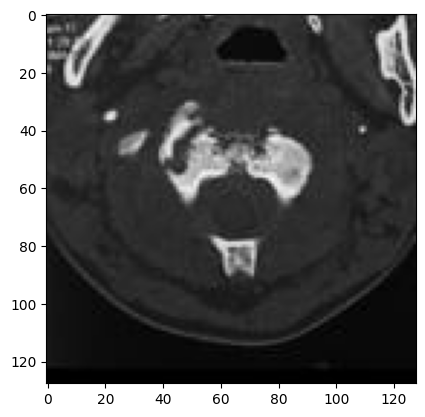

In [66]:
show_similar_images_from_text('polyp',embed_test,max_print_similar=20)

### Multi class classification accuracy 

In [52]:
df = test.copy()
num_classes = 4 # for zero shot learning (classes+other)
labels,weights = utils.get_most_common_labels(df, num_classes=num_classes)

df['labels'] = df.concepts.apply(lambda x: utils.one_hot_encode(x,labels,num_classes))
embed_test.labels = list(df['labels'])[:embed_test.text.shape[0]]
lbt = np.argmax(embed_test.labels,axis=1)
#print test['labels']

print(labels,weights)
print(Counter(lbt))

['X-Ray Computed Tomography', 'Plain x-ray', 'Magnetic Resonance Imaging', 'Ultrasonography'] [10.25112033 13.92626832 19.1810559  23.99494949  1.        ]
Counter({0: 6419, 1: 4431, 2: 3218, 3: 2572})


In [53]:
utils.print_metric(df,num_classes)

(78017,) ['Plain x-ray' 'Fracture of metacarpal bone' 'Reduced' ... 'Chest'
 'Decreased translucency' 'Homogeneity']
total test samples: 16655
total concepts with duplicates: 78017
unique concepts: 6478
max concepts per sample: 111
min concepts per sample: 2
avg concepts per sample: 16.14803183921453

concepts of sample 0: {'Plain x-ray', 'Fracture of metacarpal bone', 'Reduced'}
concepts of sample 1: {'disrupted', 'Plain x-ray', 'Malignant - descriptor', 'Deliveries by destructive operation', 'Cortex of bone', 'Structure of left shoulder region', 'Structure of head of humerus'}
concepts of sample 2: {'Plain x-ray', 'Trochlear nerve structure'}
concepts of sample 3: {'Plain x-ray', 'Measurement', 'Computed Tomography Scanning Systems'}
concepts of sample 4: {'Proximal', 'Plain x-ray', 'Dimensions', 'Measures', 'Maximal (qualifier value)', 'Neck', 'Left humerus', 'Pathological fracture'}

most common concepts: 
[('X-Ray Computed Tomography', 6025), ('Plain x-ray', 4435), ('Magnetic Reso

In [54]:
# create df from labels
same_image = ['ImageCLEFmedCaption_2022_train_067029.jpg']*(num_classes)
labels_tuples_df = pd.DataFrame({'ID':same_image,'caption':labels})

In [55]:
labels_tuples_df

ID                     caption
0  ImageCLEFmedCaption_2022_train_067029.jpg   X-Ray Computed Tomography
1  ImageCLEFmedCaption_2022_train_067029.jpg                 Plain x-ray
2  ImageCLEFmedCaption_2022_train_067029.jpg  Magnetic Resonance Imaging
3  ImageCLEFmedCaption_2022_train_067029.jpg             Ultrasonography

In [57]:
classesList = CLIP_data_load.paths_captions_emb_list(labels_tuples_df, all_images_path,tokenizer=tokenizer,max_len=max_len)
class_gen = CLIP_data_load.ClipBaseGenerator(
    data = classesList,
    batch_size = 1,
    out_shape = img_shape[0:2],
    shuffle = False,
    seed=SEED,)
#Using one as batch size otherwise labels will be cut
e_labels, _ = loaded_model.predict(class_gen,workers=2)

100%|██████████| 4/4 [00:00<00:00, 3744.08it/s]
2023-06-19 17:37:38.188435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 3s 17ms/step


In [58]:
print(e_labels.shape)

(4, 512)


In [59]:
# sample_labes has shape (num_samples,num_classes)
def add_other_class(samples_labels):
    # if a sample has only zeros concatenate a 1 at the end of the array
    # otherwise concatenate a 0
    other_class = np.array([1 if np.sum(sample) == 0 else 0 for sample in samples_labels])
    return np.concatenate((samples_labels,other_class[:,None]),axis=1)

(4, 512)
12384.0
16239.0
ground truth: [[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]
predictions: [[0. 0. 0. 0. 1.]
 [1. 1. 0. 0. 0.]
 [1. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]
Multi class accuracy: 0.4283052884615385
Single class accuracy: 0.44627403846153846
Single class confusion matrix:


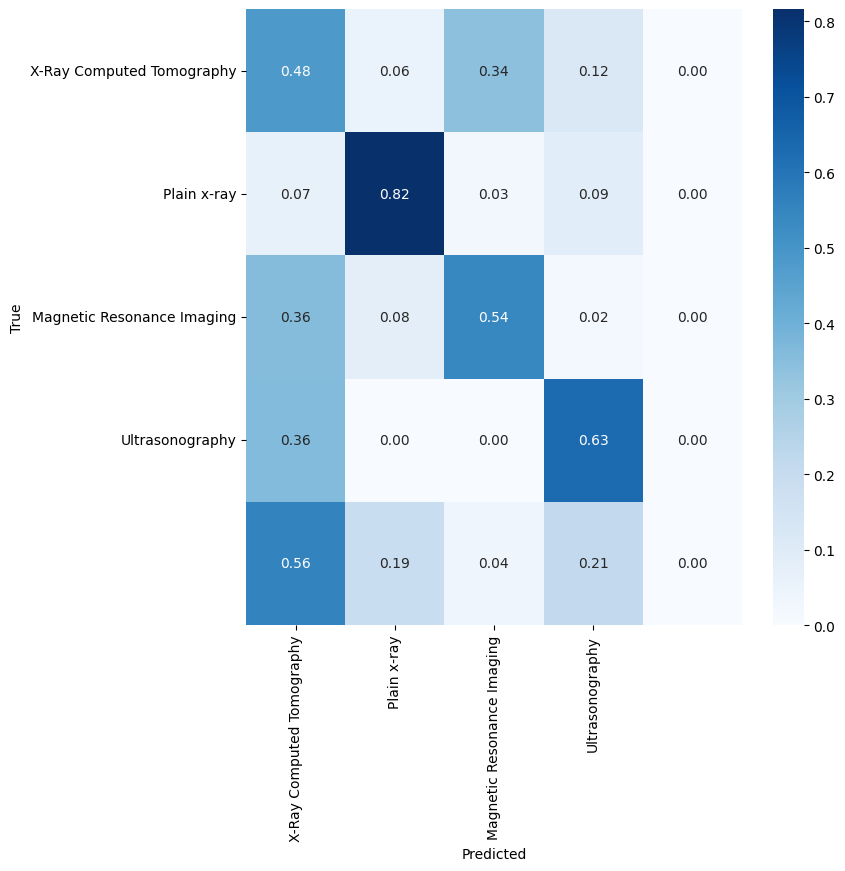

[[7956 2666]
 [3707 2311]]
[[11654   555]
 [ 1459  2972]]
[[13098   324]
 [ 1479  1739]]






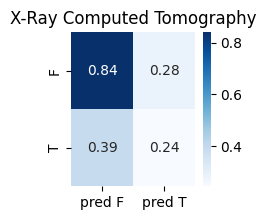

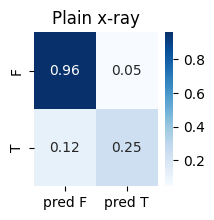

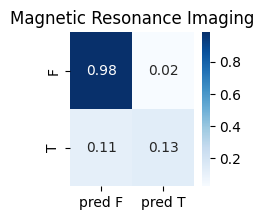

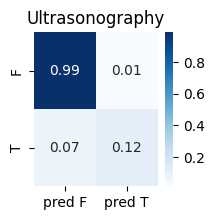

In [61]:
similarity_treshold = 0.01 # Hyperparameter. Image that have similarity higher then the treshold will belong to the class

print(e_labels.shape)
#compute similarity between each image and label
similarities = np.dot( embed_test.img,e_labels.T)
one_hot_labels = np.array(embed_test.labels)
#remove fourth class

sim_old = similarities.copy()
labels_old = one_hot_labels.copy()

similarities[similarities < similarity_treshold] = 0
similarities[similarities >= similarity_treshold] = 1

# print number of ones in each row of similarities
print(np.sum(similarities))
print(np.sum(one_hot_labels))


similarities = add_other_class(similarities)
one_hot_labels = add_other_class(one_hot_labels)

print(f'ground truth: {one_hot_labels}')
print(f'predictions: {similarities}')
# print(add_other_class(similarities))
# compute multi class metrics
print('Multi class accuracy:', accuracy_score(one_hot_labels, similarities))
# single class accuracy
one_hot_max_labels = one_hot_labels.argmax(axis=1)
max_one_hot_similarities = similarities.argmax(axis=1)


print('Single class accuracy:', accuracy_score(one_hot_max_labels, max_one_hot_similarities))

matrix = confusion_matrix(one_hot_max_labels, sim_old.argmax(axis=1),normalize='true')
print('Single class confusion matrix:')
#plot matrix
plt.figure(figsize=(8,8))
lb = labels# + ['other']
sns.heatmap(matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=lb, yticklabels=lb)
# add x and y labels
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# multi label confusion matrix
matrix = multilabel_confusion_matrix(one_hot_labels, similarities)
print(matrix[0])
print(matrix[1])
print(matrix[2])
# plot confusion matrix for each class
for i in range(num_classes):
    #plot matrix
    plt.figure(figsize=(2,2))
    #set title to class name
    plt.title(lb[i])
    xlb = ['pred F','pred T']
    ylb = ['F','T']
    mat = matrix[i]/np.linalg.norm(matrix[i])
    # cut numbers with more than 2 decimals
    sns.heatmap(mat, annot=True, fmt='.2f', cmap='Blues', xticklabels=xlb, yticklabels=ylb)
    print()

In [62]:
# write a function to find the values that maximizes accuracy
def find_best_treshold(similarities,one_hot_labels):
    best_treshold = 0
    best_acc = 0
    sim_copy = similarities.copy()
    progress = tqdm(np.arange(0,1,0.01))
    for treshold in progress:
        similarities = sim_copy.copy()
        similarities[similarities < treshold] = 0
        similarities[similarities >= treshold] = 1
        acc = accuracy_score(one_hot_labels, similarities)
        if acc > best_acc:
            best_acc = acc
            best_treshold = treshold
            progress.set_description(f"Best treshold: {best_treshold}, Best acc: {best_acc}")
    return best_treshold,best_acc

similarities = np.dot( embed_test.img,e_labels.T)
one_hot_labels = np.array(embed_test.labels)
best_treshold,best_acc = find_best_treshold(similarities,one_hot_labels)


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
#print predicted classes abor the treshold for each sample
tc = test.copy().reset_index(drop=True)
for i, (id,caption,cuis,concepts) in tc.iterrows():
    if i >= len(embed_test):
        break
    # get image embedding
    img = embed_test.img_of[id]
    # compute similarity between image and labels
    similarities = np.dot( img,e_labels.T)
    # get predicted labels
    predicted_labels = [labels[i] for i in np.where(similarities > best_treshold)[0]]
    concept_with_labels_removed = [concept for concept in concepts if concept in labels]
    print(f'predicted labels: {predicted_labels}')
    print(f'ground truth    : {concept_with_labels_removed}')
    print()
    print(i)



predicted labels: []
ground truth    : ['Plain x-ray']

0
predicted labels: ['X-Ray Computed Tomography', 'Plain x-ray']
ground truth    : ['Plain x-ray']

1
predicted labels: ['X-Ray Computed Tomography', 'Plain x-ray']
ground truth    : ['Plain x-ray']

2
predicted labels: ['X-Ray Computed Tomography', 'Plain x-ray']
ground truth    : ['Plain x-ray']

3
predicted labels: ['Magnetic Resonance Imaging']
ground truth    : ['Plain x-ray']

4
predicted labels: []
ground truth    : ['Plain x-ray']

5
predicted labels: ['Plain x-ray']
ground truth    : ['Plain x-ray']

6
predicted labels: ['Plain x-ray']
ground truth    : ['Plain x-ray']

7
predicted labels: ['Plain x-ray']
ground truth    : ['Plain x-ray']

8
predicted labels: []
ground truth    : ['Plain x-ray']

9
predicted labels: ['Plain x-ray']
ground truth    : ['Plain x-ray']

10
predicted labels: []
ground truth    : ['Plain x-ray']

11
predicted labels: ['Plain x-ray']
ground truth    : ['Plain x-ray']

12
predicted labels: ['Plai

In [68]:
!pip install tensorflow keras_cv --upgrade --quiet
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

/bin/bash: /home/ale/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/ale/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [69]:
import time
import keras_cv
from tensorflow import keras
import matplotlib.pyplot as plt

In [70]:
model = keras_cv.models.StableDiffusion(img_width=128, img_height=128)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


In [85]:
#The function prints all the superclasses of the given object
def print_superclasses(obj):
    for cls in obj.__class__.__mro__:
        print(cls.__name__)
# print_superclasses(model.img_height)
print(type(model.diffusion_model))

2023-06-19 18:38:39.182603: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 14.06MiB (rounded to 14745600)requested by op Mul
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-06-19 18:38:39.182707: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-06-19 18:38:39.182726: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 295, Chunks in use: 295. 73.8KiB allocated for chunks. 73.8KiB in use in bin. 33.9KiB client-requested in use in bin.
2023-06-19 18:38:39.182736: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 156, Chunks in use: 156. 103.0KiB allocated for chunks. 103.0KiB in use in bin. 93.5KiB client-requested in use in bin.
2023-06-19 18:38:39.182742: I tensorflow/tsl/framewo

ResourceExhaustedError: Exception encountered when calling layer "res_block_31" (type ResBlock).

in user code:

    File "/home/ale/miniconda3/envs/tf/lib/python3.11/site-packages/keras_cv/models/stable_diffusion/diffusion_model.py", line 245, in call  *
        x = layer(x)
    File "/home/ale/miniconda3/envs/tf/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None

    ResourceExhaustedError: Exception encountered when calling layer 'padded_conv2d_127' (type PaddedConv2D).
    
    in user code:
    
        File "/home/ale/miniconda3/envs/tf/lib/python3.11/site-packages/keras_cv/models/stable_diffusion/__internal__/layers/padded_conv2d.py", line 26, in call  *
            return self.conv2d(x)
        File "/home/ale/miniconda3/envs/tf/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "/home/ale/miniconda3/envs/tf/lib/python3.11/site-packages/keras/backend.py", line 2101, in random_uniform
            return tf.random.stateless_uniform(
    
        ResourceExhaustedError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:Mul]
    
    
    Call arguments received by layer 'padded_conv2d_127' (type PaddedConv2D):
      • inputs=tf.Tensor(shape=(None, 8, 8, 640), dtype=float32)


Call arguments received by layer "res_block_31" (type ResBlock):
  • inputs=['tf.Tensor(shape=(None, 8, 8, 640), dtype=float32)', 'tf.Tensor(shape=(None, 1280), dtype=float32)']

In [71]:
images = model.text_to_image("photograph of an astronaut riding a horse", batch_size=3)


def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")


plot_images(images)

492466864/492466864 [==============================] - 136s 0us/step


2023-06-19 18:31:50.181195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [1,77]
	 [[{{node Placeholder/_1}}]]
2023-06-19 18:31:51.233891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [1,77]
	 [[{{node Placeholder/_1}}]]


 177463296/3439090152 [>.............................] - ETA: 23:58

KeyboardInterrupt: 